In [38]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm
from itertools import combinations, permutations
import time

In [39]:
data_C = np.loadtxt('../data/TSPC.csv', delimiter=';').astype(np.int64)
data_D = np.loadtxt('../data/TSPD.csv', delimiter=';').astype(np.int64)

In [40]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int64)

def create_dist_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    #cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2)).round().astype(np.int64)

In [41]:
cost_matrix_C = create_cost_matrix(data_C)

In [42]:
cost_matrix_D = create_cost_matrix(data_D)

In [43]:
dist_matrix_C = create_dist_matrix(data_C)
dist_matrix_D = create_dist_matrix(data_D)

In [44]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [45]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]]
    total_sum += cost_matrix[cycle[-1], cycle[0]]
    return total_sum

In [46]:
#@jit()
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix_C, 100)
print(solution)

[ 67 190 105  88  78  87  51 154 113 178 152  33  80  20  92  12 106  14
 166 167  82 157  34  28  77 126 165 192  59 176  25 128  10  91 156 136
 137  75 139  95 155  86 135  57 112 170   6   7 117  81  11  43 127 101
  22 130 118  27  99 144 191   4 195 148 179  40 182 142  62  63 116 177
  49  37  72  18  61 198  93 180  42  94 143 189  90 145   9 174  36  50
 151  56  41  54 181 124   5  16  46 114]


In [47]:
#@jit()
def greedy_cycle(cost_matrix, current_id, limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)

    return np.array(solution)

In [48]:
# swap node in cycle and unused node
def inter_exchange_delta(cycle, cost_matrix, used_cycle_id, unused_node):
    if used_cycle_id == len(cycle)-1:
        return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[0]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[0]]
    return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[used_cycle_id+1]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[used_cycle_id+1]]

In [49]:
def intra_two_nodes_exchange_delta(cycle, cost_matrix, node1, node2, pri = False):
    # print(node1, node2)
    if node1 == len(cycle)-1:
        node1plus = 0
    else:
        node1plus = node1 + 1
    
    if node2 == len(cycle)-1:
        node2plus = 0
    else:
        node2plus = node2 + 1

    if abs(node1-node2) == 1:
        if node1 > node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]
    if abs(node1-node2) == len(cycle)-1:
        if node1 < node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

    return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1plus]] + cost_matrix[cycle[node2-1], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node1plus]] - cost_matrix[cycle[node2-1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

In [50]:
def intra_two_edges_exchange_delta(cycle, dist_matrix, node1, node2):
    if node1 == len(cycle)-1 or node2 == len(cycle)-1:
        return 99999
    #print(cost_matrix[cycle[node1], cycle[node2]], cost_matrix[cycle[node1+1], cycle[node2+1]], cost_matrix[cycle[node1], cycle[node1+1]], cost_matrix[cycle[node2], cycle[node2+1]])
    return dist_matrix[cycle[node1], cycle[node2]] + dist_matrix[cycle[node1+1], cycle[node2+1]] - dist_matrix[cycle[node1], cycle[node1+1]] - dist_matrix[cycle[node2], cycle[node2+1]]


In [51]:
#jit()
def greedy_local_search(cost_matrix, dist_matrix, nodes_exchange = True, initial_greedy = False, starting_node = None, cycle = None):
    if cycle is None:
        if initial_greedy:
            if starting_node:
                cycle = greedy_cycle(cost_matrix, starting_node)
            else:
                cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
        else:
            cycle = random_solution(cost_matrix)
    unused_nodes = set(list(range(0,len(cost_matrix))))
    for node in cycle:
        unused_nodes.remove(node)

    #neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
    #neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]

    while(True):
        best_delta, swap_node_a, swap_node_b, best_type = 0, None, None, None
        neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
        neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]
        random.shuffle(neighbourhood)
        if nodes_exchange:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_nodes_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_nodes_exchange'
                        break
        else:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_edges_exchange_delta(cycle, dist_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_edges_exchange'
                        break

        if best_type is not None:
            if best_type == 'inter_exchange':
                unused_nodes.add(cycle[swap_node_a])
                unused_nodes.remove(swap_node_b)
                cycle[swap_node_a] = swap_node_b
                #neighbourhood = [(x, y) for x in range(len(cycle)) for y in unused_nodes]
            elif best_type == 'intra_two_nodes_exchange':
                cycle[swap_node_a], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a]
            elif best_type == 'intra_two_edges_exchange':
                cycle[swap_node_a+1], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a+1]
                cycle[swap_node_a+2:swap_node_b] = cycle[swap_node_a+2:swap_node_b][::-1]
        else:
            break
    return cycle

In [52]:
def present_results(min, max, average, time, iter, best_cycle):
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format('MIN', 'MAX', 'AVG', 'TIME', 'ITER'))
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format(min, max, average, time, iter))
    print()
    return best_cycle

In [53]:
cost_matrix_C, dist_matrix_C

(array([[  42, 1790, 1367, ..., 3428, 3128, 1332],
        [1591,  241, 1667, ..., 2618, 1611,  635],
        [ 678, 1177,  731, ..., 2909, 2494,  782],
        ...,
        [2740, 2129, 2910, ...,  730, 2253, 2372],
        [2516, 1198, 2571, ..., 2329,  654, 1591],
        [1192,  694, 1331, ..., 2920, 2063,  182]]),
 array([[   0, 1549,  636, ..., 2698, 2474, 1150],
        [1549,    0,  936, ..., 1888,  957,  453],
        [ 636,  936,    0, ..., 2179, 1840,  600],
        ...,
        [2698, 1888, 2179, ...,    0, 1599, 2190],
        [2474,  957, 1840, ..., 1599,    0, 1409],
        [1150,  453,  600, ..., 2190, 1409,    0]]))

In [54]:
def generate_n_solutions(n_solutions, cost_matrix, dist_matrix):
    solutions = []
    fitness = []
    for i in tqdm(range(n_solutions), total=n_solutions):
        solutions.append(greedy_local_search(cost_matrix, dist_matrix, nodes_exchange = False, initial_greedy = False, starting_node = None, cycle = None))
        fitness.append(calculate_performance(solutions[-1], cost_matrix=cost_matrix))
    return np.array(solutions), fitness

## Lab 8

In [55]:
cycles, fitness = generate_n_solutions(10, cost_matrix=cost_matrix_C, dist_matrix=dist_matrix_C)

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [56]:
def transform_cycle(cycle):
    return set([(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))])

In [57]:
def transform_cycle_extend(cycle):
    s = set([(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))])
    s.update(set([(cycle[::-1][i], cycle[::-1][(i+1)%len(cycle)]) for i in range(len(cycle))]))
    return s

In [58]:
def calculate_similarity_edges(cycle1, cycle2):
    return len(transform_cycle(cycle1).intersection(transform_cycle_extend(cycle2)))

In [59]:
def calculate_similarity_nodes(cycle1, cycle2):
    return len(set(cycle1).intersection(set(cycle2)))

In [60]:
def calculate_similarity_average0(cycles):
    # cycles_edges_sets = list(map(lambda x: transform_cycle(x), cycles))
    average_similarity_matrix_edges = np.zeros(shape=(len(cycles), len(cycles))) 
    average_similarity_matrix_nodes = np.zeros(shape=(len(cycles), len(cycles)))

    for i in range(len(cycles)):
        for j in range(len(cycles)):
            if i == j: continue
            average_similarity_matrix_edges[i, j] = calculate_similarity_edges(cycles[i], cycles[j])
            average_similarity_matrix_nodes[i, j] = calculate_similarity_nodes(cycles[i], cycles[j])
            
    average_similarity_matrix_edges = average_similarity_matrix_edges.sum(axis=0) / (len(average_similarity_matrix_edges) - 1)
    average_similarity_matrix_nodes = average_similarity_matrix_nodes.sum(axis=0) / (len(average_similarity_matrix_nodes) - 1)
    return average_similarity_matrix_edges, average_similarity_matrix_nodes


In [61]:
def calculate_similarity_average(cycles):
    # cycles_edges_sets = list(map(lambda x: transform_cycle(x), cycles))
    average_similarity_matrix_edges = np.zeros(shape=(len(cycles), len(cycles))) 
    average_similarity_matrix_nodes = np.zeros(shape=(len(cycles), len(cycles)))

    for i in range(len(cycles)):
        for j in range(i+1, len(cycles)):
            average_similarity_matrix_edges[i, j] = calculate_similarity_edges(cycles[i], cycles[j])
            average_similarity_matrix_nodes[i, j] = calculate_similarity_nodes(cycles[i], cycles[j])
    
    average_similarity_matrix_edges = average_similarity_matrix_edges + average_similarity_matrix_edges.T
    average_similarity_matrix_nodes = average_similarity_matrix_nodes + average_similarity_matrix_nodes.T
    average_similarity_matrix_edges = average_similarity_matrix_edges.sum(axis=0) / (len(average_similarity_matrix_edges) - 1)
    average_similarity_matrix_nodes = average_similarity_matrix_nodes.sum(axis=0) / (len(average_similarity_matrix_nodes) - 1)
    return average_similarity_matrix_edges, average_similarity_matrix_nodes


In [62]:
m00, m01 = calculate_similarity_average0(cycles=cycles)

In [63]:
m10, m11 = calculate_similarity_average(cycles=cycles)

In [64]:
m00 == m10

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [65]:
m01 == m11

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [66]:
def calculate_similarity_best(cycles, fitness):
    fitness = np.array(fitness)
    # cycles_edges_sets = list(map(lambda x: transform_cycle(x), cycles))
    best_cycle_id = np.where(fitness == fitness.min())[0][0]
    best_similarity_matrix_edges = np.zeros(shape=(len(cycles)-1, )) 
    best_similarity_matrix_nodes = np.zeros(shape=(len(cycles)-1, ))
    
    j = 0
    skipped = -1
    for i in range(len(cycles)):
        if best_cycle_id == i: continue
        best_similarity_matrix_edges[j] = calculate_similarity_edges(cycles[i], cycles[best_cycle_id])
        best_similarity_matrix_nodes[j] = calculate_similarity_nodes(cycles[i], cycles[best_cycle_id])
        j += 1
    return best_similarity_matrix_edges, best_similarity_matrix_nodes, best_cycle_id

In [68]:
def plot_dataset(name, cost_matrix, dist_matrix, n_solutions=10):
    cycles, fitness = generate_n_solutions(n_solutions, cost_matrix=cost_matrix_C, dist_matrix=dist_matrix_C)
    max_fitness, min_fitness = max(fitness), min(fitness)
    
    average_similarity_matrix_edges, average_similarity_matrix_nodes = calculate_similarity_average(cycles=cycles)
    best_similarity_matrix_edges, best_similarity_matrix_nodes, skipped = calculate_similarity_best(cycles=cycles, fitness=fitness)

    min_edges, max_edges = int(min(min(average_similarity_matrix_edges), min(best_similarity_matrix_edges))), int(max(max(average_similarity_matrix_edges), max(best_similarity_matrix_edges)))
    min_nodes, max_nodes = min(min(average_similarity_matrix_nodes), min(best_similarity_matrix_nodes)), max(max(average_similarity_matrix_nodes), max(best_similarity_matrix_nodes)) 

    average_list = np.array(list(zip(average_similarity_matrix_edges, fitness)))
    average_list_sorted = np.array(sorted(average_list, key=lambda x: x[1]))

    measures_average = [average_similarity_matrix_edges, average_similarity_matrix_nodes]
    measures_best = [best_similarity_matrix_edges, best_similarity_matrix_nodes]
    measures_average = list(map(lambda x: zip(x, fitness), measures_average))
    measures_best = list(map(lambda x: zip(x, fitness[:skipped] + fitness[skipped+1:]), measures_best))
    measures = measures_average + measures_best
    
    measures = [np.array(sorted(x, key=lambda x: x[1])) for x in measures]

    min_edges, max_edges = int(min(min(average_similarity_matrix_edges), min(best_similarity_matrix_edges))), int(max(max(average_similarity_matrix_edges), max(best_similarity_matrix_edges)))
    min_nodes, max_nodes = min(min(average_similarity_matrix_nodes), min(best_similarity_matrix_nodes)), max(max(average_similarity_matrix_nodes), max(best_similarity_matrix_nodes)) 
    
    graph_names = ['Similarity graph average', 'Similarity graph best']
    for i in range(2):
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        fig.suptitle(graph_names[i])
        
        axs[0].scatter(measures[i*2][:, 1], measures[i*2][:, 0], label='Data point', c='tab:blue')
        m, b = np.polyfit(measures[i*2][:, 1], measures[i*2][:, 0], 1)
        axs[0].plot(measures[i*2][:, 1], m*measures[i*2][:, 1]+b, label='Regression line', c='tab:brown')
        
        axs[0].axis(xmin=min_fitness-100, xmax=max_fitness+100, ymin=min_edges-2, ymax=max_edges+2)
        axs[0].set_xlabel("Solution Performace")
        axs[0].set_ylabel('Similarity')
        axs[0].set_title(f'Edges')
        axs[0].yaxis.get_major_locator().set_params(integer=True)
        axs[0].set_yticks(np.arange(min_edges-1, max_edges+1, 4))
        axs[0].legend(loc=1)
        
        values, base = np.histogram(measures[i*2][:, 1])
        pdf = values / sum(values)
        cdf = np.cumsum(pdf)
        
        ax02 = axs[0].twinx()
        ax02.plot(base[:-1], cdf, c='red', label='Probability')
        ax02.set_ylabel('CDF')
        ax02.set_ylim(0, 1)
        
        plt.legend(loc=2)
        
        
        ####################################################

        
        axs[1].scatter(measures[i*2+1][:, 1], measures[i*2+1][:, 0], label='Data point', c='tab:blue')
        m, b = np.polyfit(measures[i*2+1][:, 1], measures[i*2+1][:, 0], 1)
        axs[1].plot(measures[i*2+1][:, 1], m*measures[i*2+1][:, 1]+b, label='Regression line', c='tab:brown')

        axs[1].axis(xmin=min_fitness-50, xmax=max_fitness+50, ymin=min_nodes-2, ymax=max_nodes+2)
        axs[1].set_xlabel("Solution Performace")
        axs[1].set_ylabel('Similarity')
        axs[1].set_title(f'Nodes')
        axs[1].legend(loc=1)

        values, base = np.histogram(measures[i*2+1][:, 1])
        pdf = values / sum(values)
        cdf = np.cumsum(pdf)
        
        ax12 = axs[1].twinx()
        ax12.plot(base[:-1], cdf, c='red', label='Probability')
        ax12.set_ylabel('CDF')
        ax12.set_ylim(0, 1)

        plt.legend(loc=2)
        plt.show()


        print()
        print(np.corrcoef([measures[i*2][:, 1], measures[i*2][:, 0]]))
        print()
        print(np.corrcoef([measures[i*2+1][:, 1], measures[i*2+1][:, 0]]))
        print()
        
    return measures
    

100%|██████████| 1000/1000 [42:09<00:00,  2.53s/it]


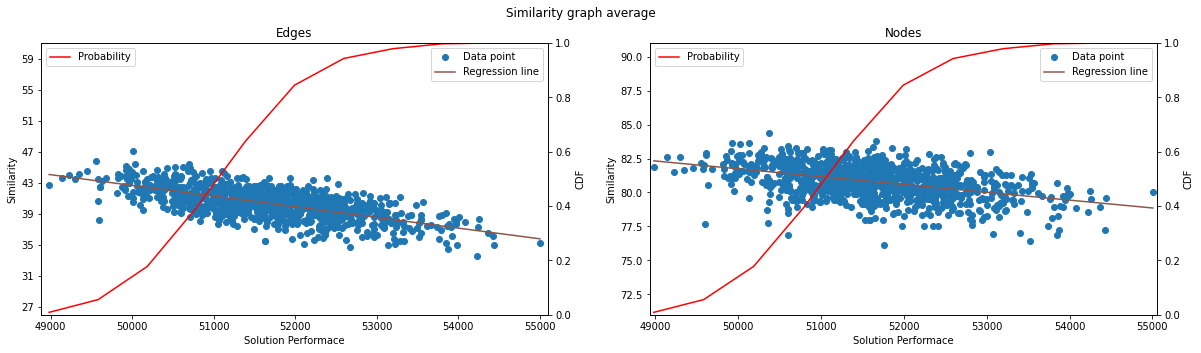


[[ 1.         -0.66218574]
 [-0.66218574  1.        ]]

[[ 1.         -0.44151185]
 [-0.44151185  1.        ]]



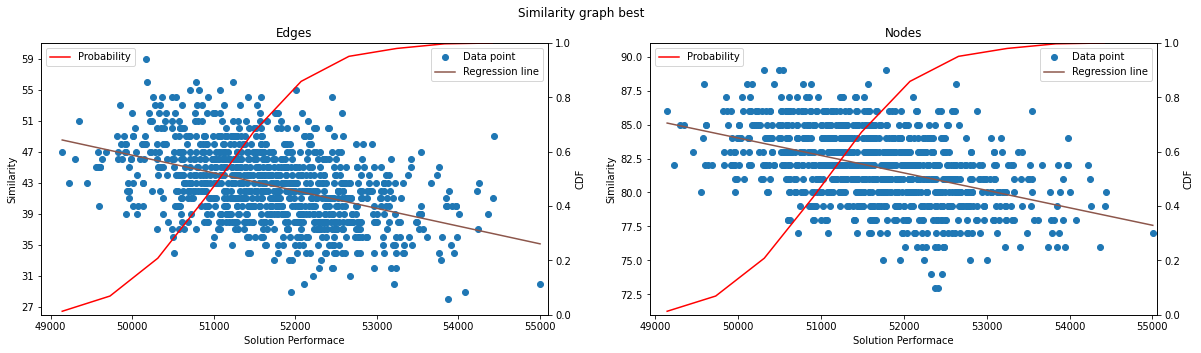


[[ 1.         -0.44380116]
 [-0.44380116  1.        ]]

[[ 1.         -0.44976305]
 [-0.44976305  1.        ]]



In [236]:
measures_c = plot_dataset('sigma', cost_matrix=cost_matrix_C, dist_matrix=dist_matrix_C, n_solutions=1000)

100%|██████████| 1000/1000 [42:11<00:00,  2.53s/it]


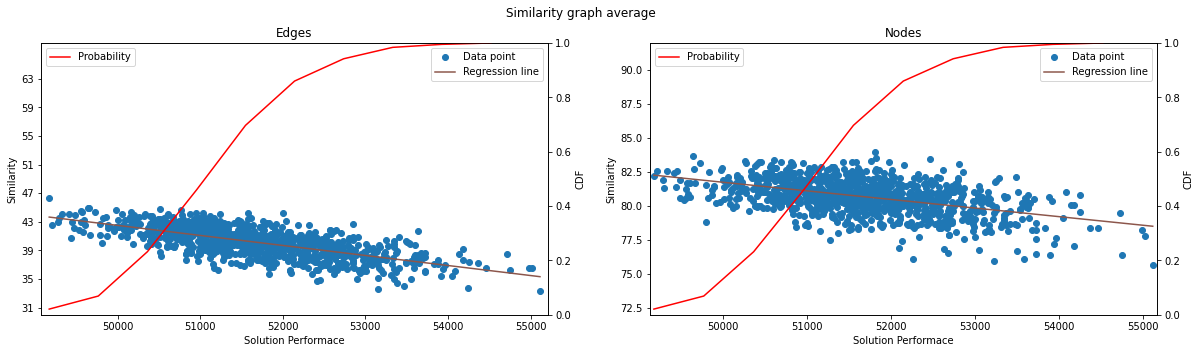


[[ 1.         -0.67878796]
 [-0.67878796  1.        ]]

[[ 1.         -0.48518495]
 [-0.48518495  1.        ]]



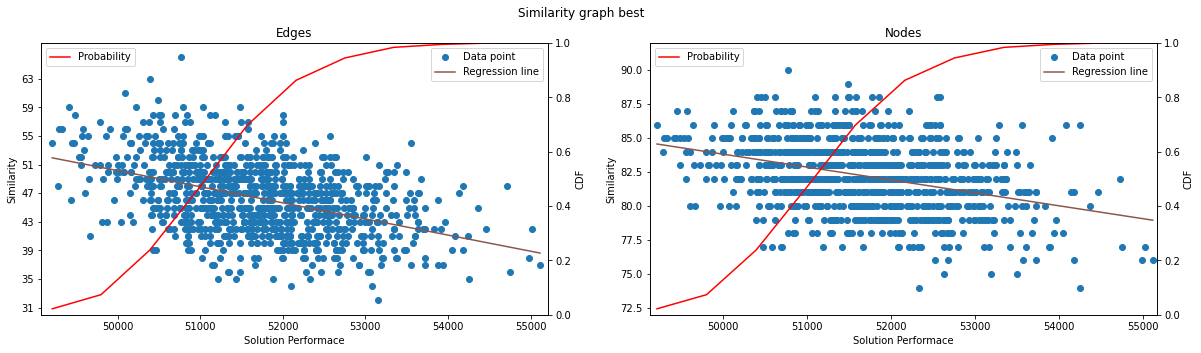


[[ 1.         -0.44037119]
 [-0.44037119  1.        ]]

[[ 1.         -0.36831234]
 [-0.36831234  1.        ]]



In [237]:
measures_d = plot_dataset('sigma D', cost_matrix=cost_matrix_D, dist_matrix=dist_matrix_D, n_solutions=1000)